In [1]:
import tensorflow as tf

# import tensorflow_io as tfio

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython import display

print(tf. __version__)
import seaborn as sns
import librosa.display

import soundfile
import statistics
import librosa as lb
# print(tfio. __version__)
import shutil
import random
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

from datetime import datetime


2.6.0


In [2]:
dataSetPath = '../processed_audio_files_nn/'
#dataSetPath = 'processed_audio_files/'
disease_labels = ["Asthma","COPD","Bronchiectasis","Pneumonia","URTI","Healthy","Bronchiolitis","LRTI"]
target_conditions = ["COPD","Healthy"]

In [3]:
def getFilenameInfo(file):
    return file.split('_')

Following loop will run through the dataset path and and analyse it


In [4]:
def plotDataSet(dataSetPath , disease_labels):
  '''plots the data-set's ingredients, and returns a dictionary with the results'''
  audio_data_dir = dataSetPath + "*.wav"
  filenames = os.listdir(dataSetPath)
  dataCountList = [0 for i in range(len(disease_labels))]
  for filename in filenames:
    dataCountList[disease_labels.index(getFilenameInfo(filename)[0])] += 1

  # print(dataCountList,dataCountList)

  plt.bar(disease_labels,dataCountList)
  plt.xticks(rotation=90)
  dataSetInfo = {disease_labels[i] : dataCountList[i] for i in  range(len(dataCountList))}    #dictionary with data set consistancy
  return dataSetInfo

## Data set Visualization

{'Asthma': 6,
 'COPD': 5746,
 'Bronchiectasis': 104,
 'Pneumonia': 285,
 'URTI': 243,
 'Healthy': 322,
 'Bronchiolitis': 160,
 'LRTI': 32}

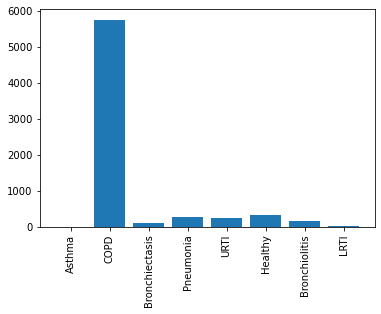

In [5]:
plotDataSet(dataSetPath , disease_labels)

## Data pre-process

copy the required files to a specific location


In [6]:
def copy_targetConditions(targets = [], destination = 'target_conditions/',source = 'balanced_dataset/'):
    '''copy the files with names in target conditions list to the destination location'''
    files = os.listdir(source)
    if not os.path.exists(destination):
        os.makedirs(destination)
    for file in files:
        if (getFilenameInfo(file)[0] in targets):
            # print(getFilenameInfo(file)[0])
            shutil.copy(source + file , destination)
            


In [7]:
 #copy_targetConditions(targets = target_conditions, destination = 'target_conditions/',source = 'balanced_dataset/')

{'COPD': 792, 'Healthy': 770}

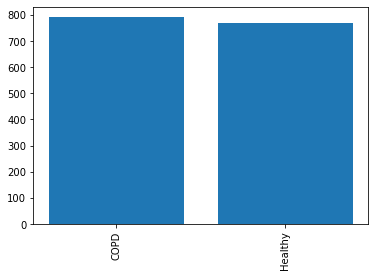

In [8]:
plotDataSet('../target_conditions/' , target_conditions)

In [9]:
max_pad_len = 862 # to make the length of all MFCC equal

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

load data

In [10]:
dataSetPath = '../target_conditions/'

files = os.listdir(dataSetPath)
# shuffle the data
random.shuffle(files)

labels = np.array([getFilenameInfo(file)[0] for file in files])
# print (str(labels[:10]) + 'files : ' + str(files[:10]))

# print(files)

## Feature Extraction

In [11]:
features = []

for file in files:
    features.append(extract_features(dataSetPath+file))

features = np.array(features,dtype=float )
print('feature extraction finished with : ' , len(features) , "features.")



feature extraction finished with :  1562 features.


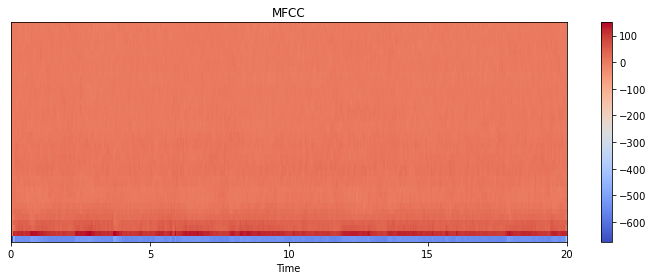

In [12]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(features[0], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

## Encode and Split

In [13]:
le = LabelEncoder()
i_labels = le.fit_transform(labels)
oneHotLabels = to_categorical(i_labels)
# print(oneHotLabels[:10])

features = np.reshape(features,(*features.shape,1))


#split the data set

x_train,x_test,y_train,y_test = train_test_split(features,oneHotLabels,stratify=oneHotLabels,test_size=0.3,random_state = 42)
x_test,x_val,y_test,y_val = train_test_split(features,oneHotLabels,stratify=oneHotLabels,test_size=0.2,random_state = 42)


tensor_x_test = tf.convert_to_tensor(x_test)
print(len(x_val))


313


## Model creation

In [14]:
num_rows = 40
num_columns = 862
num_channels = 1

num_labels = oneHotLabels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [15]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [16]:
# Display model architecture summary 
model.summary()


# Calculate pre-training accuracy 
print(type(x_test))
tensor_y_test = tf.convert_to_tensor(y_test)


score = model.evaluate(tensor_x_test, tensor_y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 861, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 430, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 430, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 429, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 214, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 214, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 213, 64)        8

In [17]:
array = np.array([[1,2,3],[3,4,5],[5,6,7]])
print("This is a numpy array:")
print(array, array.shape, type(array))
tensor = tf.convert_to_tensor(array)
print("Converted numpy array into tensor:")
print(tensor)

This is a numpy array:
[[1 2 3]
 [3 4 5]
 [5 6 7]] (3, 3) <class 'numpy.ndarray'>
Converted numpy array into tensor:
tf.Tensor(
[[1 2 3]
 [3 4 5]
 [5 6 7]], shape=(3, 3), dtype=int32)


## Model Training

In [18]:
# train model
num_epochs = 100
num_batch_size = 128

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
9/9 [==============================] - 7s 500ms/step - loss: 6.5793 - accuracy: 0.5572 - val_loss: 0.9814 - val_accuracy: 0.6189

Epoch 00001: val_accuracy improved from -inf to 0.61890, saving model to mymodel2_01.h5
Epoch 2/100
9/9 [==============================] - 2s 211ms/step - loss: 3.0141 - accuracy: 0.5279 - val_loss: 1.0754 - val_accuracy: 0.5044

Epoch 00002: val_accuracy did not improve from 0.61890
Epoch 3/100
9/9 [==============================] - 2s 204ms/step - loss: 1.1382 - accuracy: 0.7219 - val_loss: 0.4645 - val_accuracy: 0.7502

Epoch 00003: val_accuracy improved from 0.61890 to 0.75020, saving model to mymodel2_03.h5
Epoch 4/100
9/9 [==============================] - 2s 213ms/step - loss: 0.6152 - accuracy: 0.7868 - val_loss: 0.3608 - val_accuracy: 0.8167

Epoch 00004: val_accuracy improved from 0.75020 to 0.81665, saving model to mymodel2_04.h5
Epoch 5/100
9/9 [==============================] - 2s 209ms/step - loss: 0.5267 - accuracy: 0.8554 - val_lo

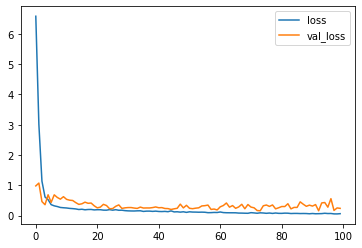

In [19]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Testing

In [20]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8645928502082825
Testing Accuracy:  0.8646917343139648


In [21]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=2 # number of classes

[[628   5]
 [164 452]]


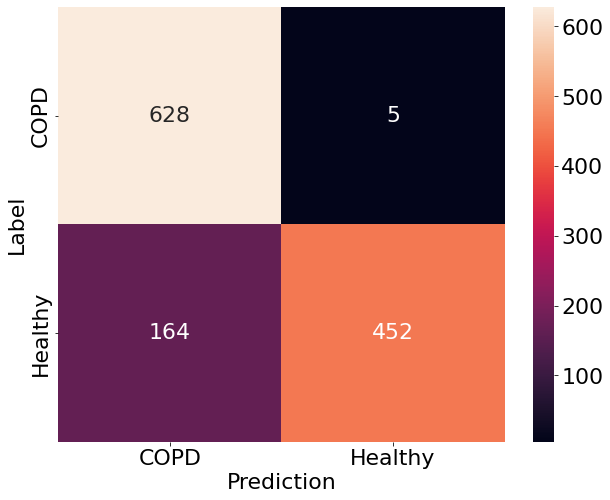

In [22]:


print(confusion_matrix(y_testclass, classpreds))

confusion_mtx = tf.math.confusion_matrix(y_testclass, classpreds)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=target_conditions,
            yticklabels=target_conditions,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run Inferance

[[0.61236554 0.38763452]]


<BarContainer object of 2 artists>

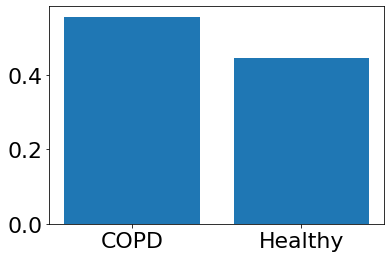

In [24]:
sample_file = '../target_conditions/Healthy_187_1b1_Ll_sc_Meditron_copy_21.wav'
sample_ds = []
sample_ds.append(extract_features(sample_file))
sample_ds = np.array(sample_ds)
sample_ds = np.reshape(sample_ds,(*sample_ds.shape,1))
# print(sample_ds)
prediction = model.predict(sample_ds)
print(prediction)
plt.bar(target_conditions, tf.nn.softmax(prediction[0]))
  # plt.title(f'Predictions for "{disease_labels[label[0]]}"')
  # plt.show()